# Self-supervised Monocular Depth Estimation

University of Waterloo, CS484: Final Project

Daniel Herbst (`dherbst@uwaterloo.ca`, `daniel.herbst@tum.de`)

In this project, I implemented the self-supervised approach for monocular depth estimation presented in the 2017 CVPR paper 

*Unsupervised Monocular Depth Estimation with Left-Right Consistency* 
by Clément Godard, Oisin Mac Aodha, and Gabriel J. Brostow 
(https://arxiv.org/pdf/1609.03677.pdf).

Depth estimation is a very typical problem encountered in Computer Vision that has a 
variety of applications, the most prominent one being autonomous driving. While it is 
necessary for autonomous vehicles to map their surroundings in order to navigate 
correctly, there are many ways to achieve this: One can use sophisticated sensors as radar
or even Lidar technologies. However, a completely different and potentially cheaper 
approach is to equip vehicles with cameras and use Computer Vision methods to estimate 
depth from these images, casting these estimated depths out in order to create 3D mappings
of the environment. 

Although there are conventional methods for depth estimation (or equivalently disparity 
estimation) from calibrated stereo images, machine learning approaches using convolutional 
neural networks (CNNs) have been getting increasingly popular over the last years, 
outperforming these conventional methods. While one would need ground truths for a naïve 
supervised learning approach to estimate the disparity maps, such disparity maps might not 
always be available or very tedious/expensive to annotate. The very influential paper from
2017 above resolves this issue by training to estimate disparity maps for rectified stereo
image pairs -- but only taking the left image as an input for the estimation of the 
disparity maps, using the right image in the loss function to check consistency. The 
elegance of this approach is that when such a model is deployed, only the left image is 
needed to perform the actual depth (disparity) estimation which is a clear advantage over 
conventional stereo methods that always require image pairs. This method is called 
self-supervised since there is no annotated ground truth depth information needed for 
training, but only the image pairs -- which makes the collection of massive amounts of 
training data very easy and cheap. 

The original paper comes with a reference implementation in TensorFlow 
(https://github.com/mrharicot/monodepth). While I partly used this to infer tiny 
implementation details that were not entirely clear from the paper, the inspiration 
for the general structure of e.g. the model implementation also comes from this reference 
implementation. Furthermore, this project aims to

- provide a simple and lightweight implementation of the method in the paper using PyTorch
- give a brief overview of this method without the need to read the original paper, 
combining explanations with implementation.

## Method description

### High-level idea

The high-level idea for self-supervised monocular depth estimation as presented in the reference paper is the following: Suppose we want to infer depth $\hat{d}$ from an image $I$ by learning a function $\hat{d} = f(I)$. Suppose also that there is access to observations of calibrated stereo image pairs $(I^l, I^r)$ during training, however there is no ground truth depth information about the images available. Furthermore, for testing or deployment of the system only single images are available. 

In this situation, the key insight on which the paper is based is that one can learn a neural network that maps the left image $I^l$ to a disparity map $d^r$ (from the left to the right image), which then applied to $I^l$ yields a reconstruction of the right image from the left image:

$$
    I^r \: \approx \: \tilde{I}^r \: := \: I^l(d^r) 
$$

If the disparity map $d^r$ was perfect, $I^r$ would be very similar or even equal to its reconstruction $\tilde{I}^r$. Hence, if one wants to learn the disparity map (i.e. just a single real value for each pixel which corresponds with the disparity in direction of $x$, since the epipolar lines are just parallel to the $x$ axis) with a neural network, one can define a loss function based on how well the reconstructed image $\tilde{I}^r$ approximates the real image $I^r$.
Finally, depth can be recovered as $\hat{d} = bf/d$, where $b$ is the baseline distance between the two cameras and $f$ is the camera focal length. For the sake of this project, we just work with the disparity maps and won't bother converting these into actual depth maps, since both are just monotone transformations of one another and we only perform a qualitative analysis of the results afterwards. 

### Method

While the aforementioned high-level idea gives a good intuition for how the model is able to learn, the actual approach proposed in the paper is a bit more complex: Basically, when only the left image $I^l$ is available during test time, with this naïve approach disparity maps aligned with the right image $I^r$ will be estimated during test time (where only the left image is available). The authors resolve this issue by predicting two disparity maps $d^r$ and $d^l$ that are subsequently used to warp the left image on the right one and the other way around. Thus, to compute the loss of the neural network, two image similarities have to be taken into account:

$$
    I^r \: \approx \: \tilde{I}^r \: := \: I^l(d^r) 
    \qquad \text{and} \qquad
    I^l \: \approx \: \tilde{I}^l \: := \: I^r(d^l) 
$$

Note that both $d^r$ and $d^l$ are still estimated only from the left image $I^l$, the right image is just used to compute the loss.

![](myimages/figures/approach_figure.jpg)

*This figure shows the naïve approach I discussed in the "high-level idea" section, alongside with another approach to just estimate the left disparity maps $d^l$ and the approach used by the authors. This figure was taken from the original paper (Figure 3).*

The specific CNN used for this approach has a encoder-decoder architecture, progressively reducing the size of the input and increasing the number of channels in the first half, while doing the opposite in the second half. In the decoder phase, disparity maps for 4 different scales of the image, becoming progressively finer, are created (at downscaling factors of 8, 4, 2, and 1) that are all returned and used as input for the loss function. Specifically, the output of the CNN is a 4-tuple of disparity maps of shapes `[2, H, W]` where `H` and `W` are the original image scaled by 1, 2, 4, and 8 respectively. The first dimension of size 2 indicates the left-to-right disparity maps (index 0) and right-to-left disparity maps (index 1) respectively. The individual disparity values range from 0 to 0.3, indicating the proportion of the total image width. 
The exact architecture with all involved layers can be seen in the following table.

![](myimages/figures/layers_table.jpg)

*This table shows the exact architecture of the encoder-decoder model. The figure was taken directly from the original paper (Table 1 in the supplementary material).*

For clarity of this notebook, the complete implementation of this model is not part of the notebook, but included in `mylibs/model.py` (class `MonoDepthModel`).

Note that if one predicts disparities, say by reconstructing the right image from the left one, the will always be areas at the left border of the left image which are not part of the right image. Clearly, for these parts of the images, the model will find no reliable way to infer any disparities, which is why estimation at the very left side of the left image (and the very right part of the right image) will be bad (in our case, just constant disparities are predicted all the time). At validation time and for future deployment of the model, one therefore does the following:

- Use the test image to produce a disparity map.
- Make a left-right flip of the test image, produce a disparity map, and flip this disparity map back again.
- Blend the two predicted disparity maps, giving higher weight to the standard one on the right side of the image and giving more weight to the flipped one on the left side (I found that weighting the two disparity maps with sigmoid functions on a range from -10 to 10 works quite well).

In the actual model definition in `MonoDepthModel`, one should therefore not merely use a forward pass of the model for estimating the depths (disparities), but use the method `blend_disp` instead.

### Loss functions

As the neural network outputs disparity maps on 4 scales, a loss is computed for each of the 4 scales separately (using downsampled versions of the left and right images) and then aggregated over the scales to obtain a total loss. If $C_s$ is the loss for a specific scale $s$, the total loss of the neural network is computed as 

$$
    C \: := \: \sum_{i=1}^4 C_s \text{.}
$$

For each scale, $C_s$ consists of parts for appearance matching (to ensure that both reconstructed images are similar to their targets), disparity smoothness, and left-right disparity consistency (to ensure that the two learned disparity maps are coherent):

$$
    C_s \: = \: \alpha_{ap} (C_{ap}^l + C_{ap}^r) + \alpha_{ds} (C_{ds}^l + C_{ds}^r) + \alpha_{lr} (C_{lr}^l + C_{lr}^r)
$$

where $\alpha_{ap}, \alpha_{ds}, \alpha_{lr}$ are the weights assigned to each part of the loss and $C_{ap}$ is the appearance matching part, $C_{ds}$ is the disparity smoothness part, and $C_{lr}$ is the left-right consistency part, each computed in a symmetric way for both the left and right images (indicated by $l$ and $r$). The weights are $\alpha_{ap} = \alpha_{lr} = 1$ just as in the original paper.
For clarity, all losses are implemented in `mylibs/losses.py` and can be accessed via the `MonoDepthLosses` class. 

#### Appearance matching loss

The authors propose an appearance similarity loss as a combination of the Structural Similarity Index Measure (SSIM) (see https://en.wikipedia.org/wiki/Structural_similarity), which is a widely used method for measuring the similarity of two images that also makes use of spatial coherence/dependence in images compared to normal $L^p$ distances, and a normal $L^1$ loss. The loss is computed in a pixel-wise fashion and then averaged over the $N$ input pixels of an image. 

$$
    C_{ap}^l \: = \: \frac{1}{N} \sum_{i, j}
    \left(
        \alpha \frac{1 - \mathrm{SSIM}(I_{ij}^l, \tilde{I}_{ij}^l)}{2} + (1 - \alpha) \left\| I_{ij}^l - \tilde{I}_{ij}^l \right\|
    \right)
$$

Here, $I_{ij}^l \in [0, 1]^3$ denotes the RGB pixel values and $\alpha = 0.85$ weights the SSIM part against the $L^1$ part. The loss $C_{ap}^r$ is computed in the exact same way.

I implemented the appearance matching loss in the method `MonoDepthLosses.appearance_matching_loss`.

#### Disparity smoothness loss

This term is added to the total loss in order to ensure that the predicted disparities are smooth and do not change rapidly. Although disparity or depth maps are most likely not smooth or even continuous, in most cases pixels with depth discontinuities also exhibit large image gradients (e.g. the boundary between an object in the front and the background). Therefore, the disparity gradients are weighted by a factor that depends on the image gradients at the same position, penalizing disparity maps less for being discontinuous if image gradients are large. 

$$
    C_{ds}^l \: = \: \frac{1}{N} \sum_{i, j}
    \left(
        | \partial_x d_{ij}^l | e^{- \| \partial_x I_{ij}^l \|} + 
        | \partial_y d_{ij}^l | e^{- \| \partial_y I_{ij}^l \|}
    \right)
$$

Again, the loss for the right image is computed in the exact same way and my implementation of the disparity smoothness loss can be found in `MonoDepthLosses.disparity_smoothness_loss`. , The weight $\alpha_{ds}$ which is used for adding the disparity smoothness loss to the total loss differs for every scale since image/disparity gradients are expected to be larger for the downsampled versions of the images. I took the exact same values as the authors, setting $\alpha_{ds} = 0.1$ for the largest scale and dividing the weight by 2, 4, and 8 for the smaller scales respectively. 


#### Left-right disparity consistency loss

This term is added to the loss to ensure that both the left and the right disparity maps are consistent with one another and the net does not learn something completely different for the two images.

$$
    C_{lr}^l \: = \: \frac{1}{N} \sum_{i, j} \left| d_{ij}^l - d_{ij + d_{ij}^l}^r\right|
$$

Again, the loss $C_{lr}^r$ is defined by just substituting $l \leftrightarrow r$ in the above formula and my implementation can be found in `MonoDepthLosses.disparity_consistency_loss`.

## Training

Due to time constraints and because training with a large amount of data can take quite long, I decided to train the model on just a chunk of the KITTI dataset which can be downloaded with the download script `download_data.sh`.

Just like in the original paper, the images are augmented for training, meaning that left and right images are mirrored randomly, and color adjustments as brightness, constrast, and hue are also performed randomly. 
Furthermore, I resized all images from their default size of $1242 \times 375$ to just $768 \times 256$. I chose this specific resolution for the following reasons:

- Smaller sizes make training faster, allowing for better results and a shorter feedback cycle -- especially considering limited time, disk space and computational resources.
- The aspect ratio of the original images stays about the same and there is no need to crop significant parts of the image.
- I chose both width and height to be multiples of 128 since this makes the steps of downsampling and upsampling in the model easier as in each of these steps, the dimensions of the images are scaled by 2 or 1/2 and power of 2 make this model less tedious to debug.

I trained the model for 50 epochs, leaving the training parameters used in the original paper untouched (i.e. learning rate and weight decay). However, contrary to the authors of the original paper, choosing a batch size of 16 instead of 8 worked better for me. Nonetheless, training was very unstable, with the optimization getting stuck in a local minimum of a total loss of roughly 2.4 at which just constant disparity maps are produced. After countless attempts, the only thing that worked to get the error further down was overfitting the model to a smaller amount of data (just the `2011_09_26_drive_0001_sync` chunk), and using this prefit model for training on my whole dataset. This can be seen in the loss curve as the losses already start at below 2, while the loss of a model with random parameters used for initialization would typically be between 3.5 and 4.

Training was carried out using the Standard GPU on Google Colab, with the training time for the 50 epochs totaling approximately 2 full days. Unfortunately, my GPU resources were used up halfway through the 46th epoch, which is why training stopped at this point and my last intermediate result is from after the 45th epoch. However, I would not expect the results to change significantly after retraining for 5 more epochs as the loss already started stagnating after 30-40 epochs.

I saved a state dict of the trained model which can be downloaded with `download_models.sh`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader

from mylibs.data_loading import KITTIDataset
from mylibs.model import MonoDepthModel
from mylibs.losses import MonoDepthLoss

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

print(f'Using {device} as a device!')

Using cpu as a device!


In [3]:
# Training hyperparameters
num_epochs = 50
lr = 0.0001
betas = (0.9, 0.999)
eps = 1e-8
steps = [30, 40, 45]
gamma = 0.5
batch_size = 16

In [4]:
# Data loading

# Training data
data_train = KITTIDataset(root='data/train', width=768, height=256)
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)

# Validation data
data_val = KITTIDataset(root='data/val', width=768, height=256, augment=False)

# Output sample sizes
len(data_train), len(data_val)

(15884, 482)

In [5]:
# Initialize model and loss
mono_depth_model = MonoDepthModel().to(device)
mono_depth_loss = MonoDepthLoss(device)

# Initialize Adam optimizer
optimizer = Adam(mono_depth_model.parameters(), lr=lr, betas=betas, eps=eps)

# Initialize learning rate scheduler
scheduler = MultiStepLR(optimizer, steps, gamma=gamma)

In [ ]:
# Training
mono_depth_model.train()
losses = []

for epoch in tqdm(range(num_epochs)):

    for batch_idx, (img_left, img_right) in enumerate(dataloader_train):
        
        # Move data to device
        img_left, img_right = img_left.to(device), img_right.to(device)

        # Apply encoder/decoder
        disp_scales = mono_depth_model(img_left)

        # Compute total loss
        loss = mono_depth_loss.total_loss(img_left, img_right, disp_scales)

        # Backward pass and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print/store current loss
        print(f'Epoch {epoch:02d}, Iteration {batch_idx:02d}, Loss: {loss.item():10.6f}')
        losses.append(loss.item())

    # Save model and losses after each epoch
    torch.save(mono_depth_model.state_dict(), open('trained_models/new/model_state_dict.sav', 'wb'))
    pd.Series(losses).to_csv('trained_models/new/losses.csv')

Text(0, 0.5, 'Total loss')

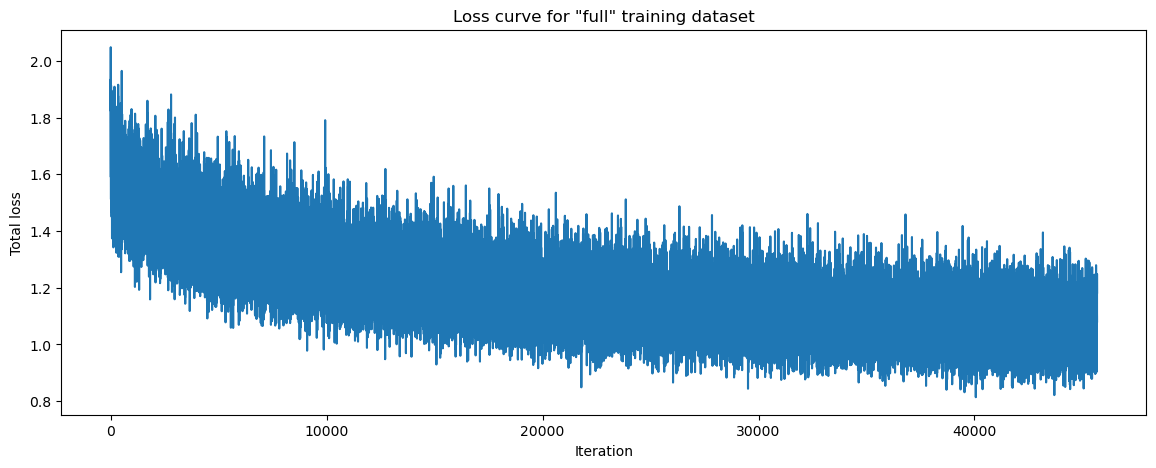

In [6]:
# Plot loss curve
losses = pd.read_csv('trained_models/losses.csv')['0']
plt.figure().set_size_inches(14, 5)
plt.plot(losses)
plt.title('Loss curve for "full" training dataset')
plt.xlabel('Iteration')
plt.ylabel('Total loss')

In [7]:
# Load my trained model
mono_depth_model.load_state_dict(torch.load(open('trained_models/model_state_dict.sav', 'rb'), map_location=torch.device(device)))

<All keys matched successfully>

### Evaluate fit of the model on training data

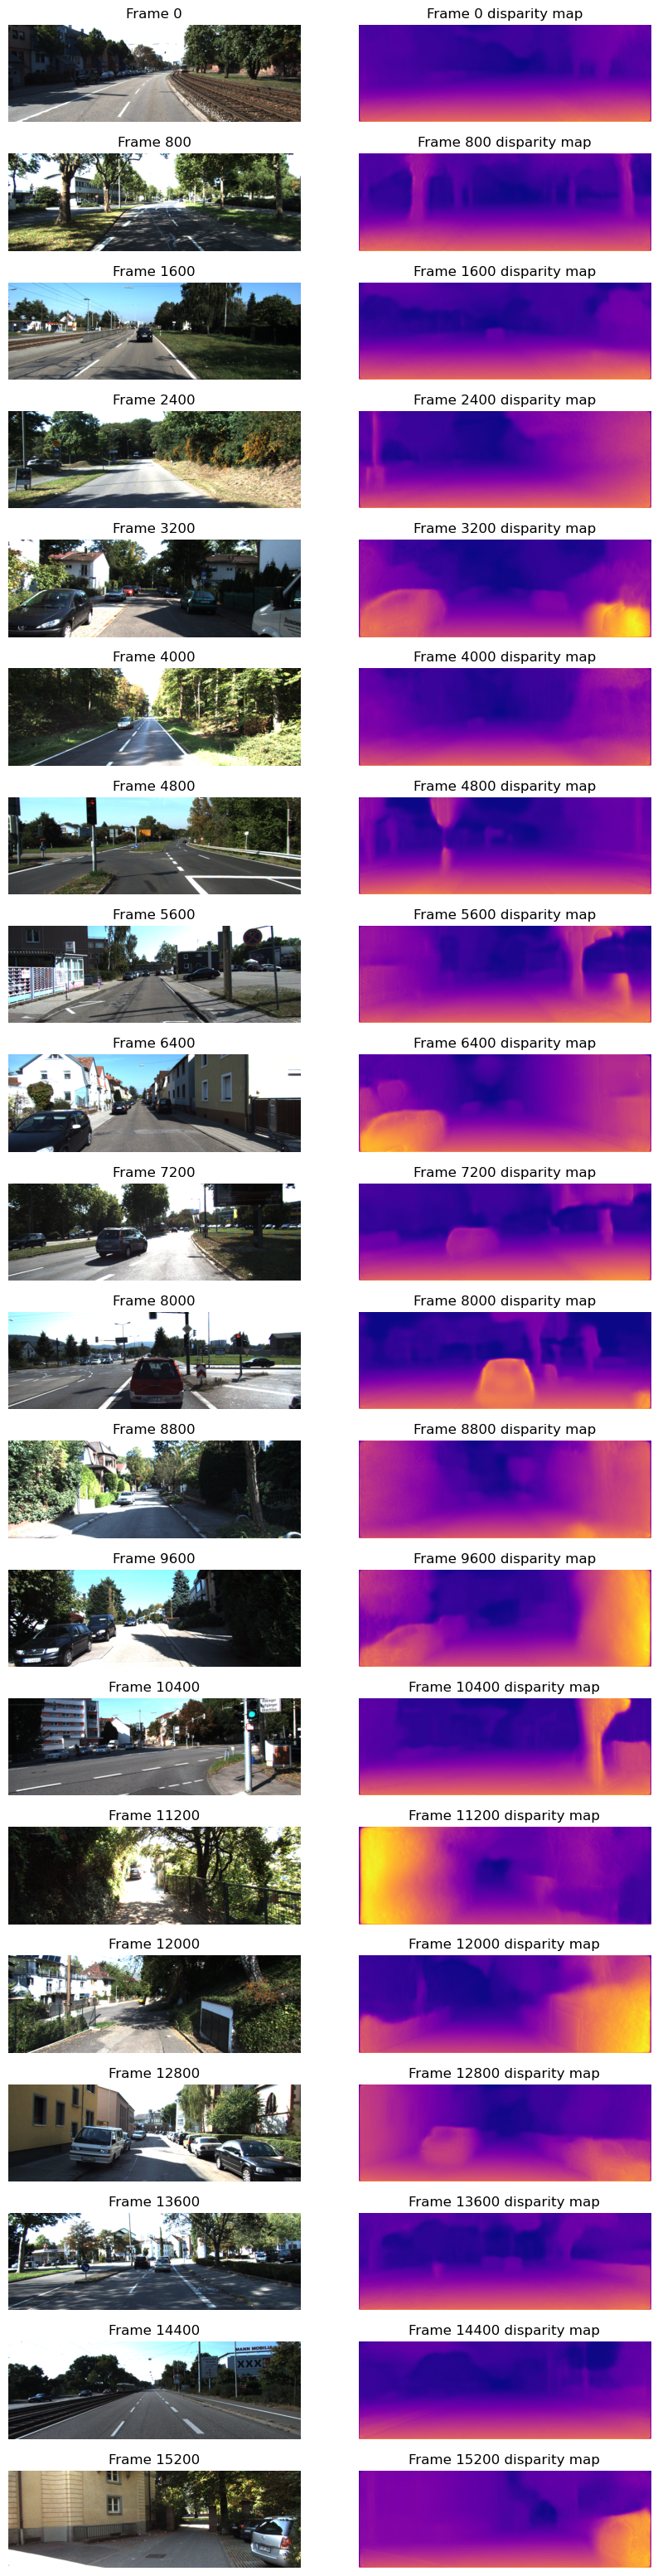

In [9]:
# Plot a few example images and estimated disparity maps (only left)
mono_depth_model.eval()
data_train.augment = False

plt.figure().set_size_inches(10, 40)

for i, frame in enumerate(range(0, len(data_train), 800)):
    
    img_left, _ = data_train[frame]
    disp = mono_depth_model.blend_disp(img_left)

    plt.subplot(20, 2, 2*i+1)
    plt.imshow(img_left.permute(1, 2, 0).detach().numpy())
    plt.title(f'Frame {frame}')
    plt.gca().axis('off')

    plt.subplot(20, 2, 2*i+2)
    plt.imshow(disp.detach().numpy(), cmap='plasma')
    plt.title(f'Frame {frame} disparity map')
    plt.gca().axis('off')

### Qualitative evaluation on unseen data

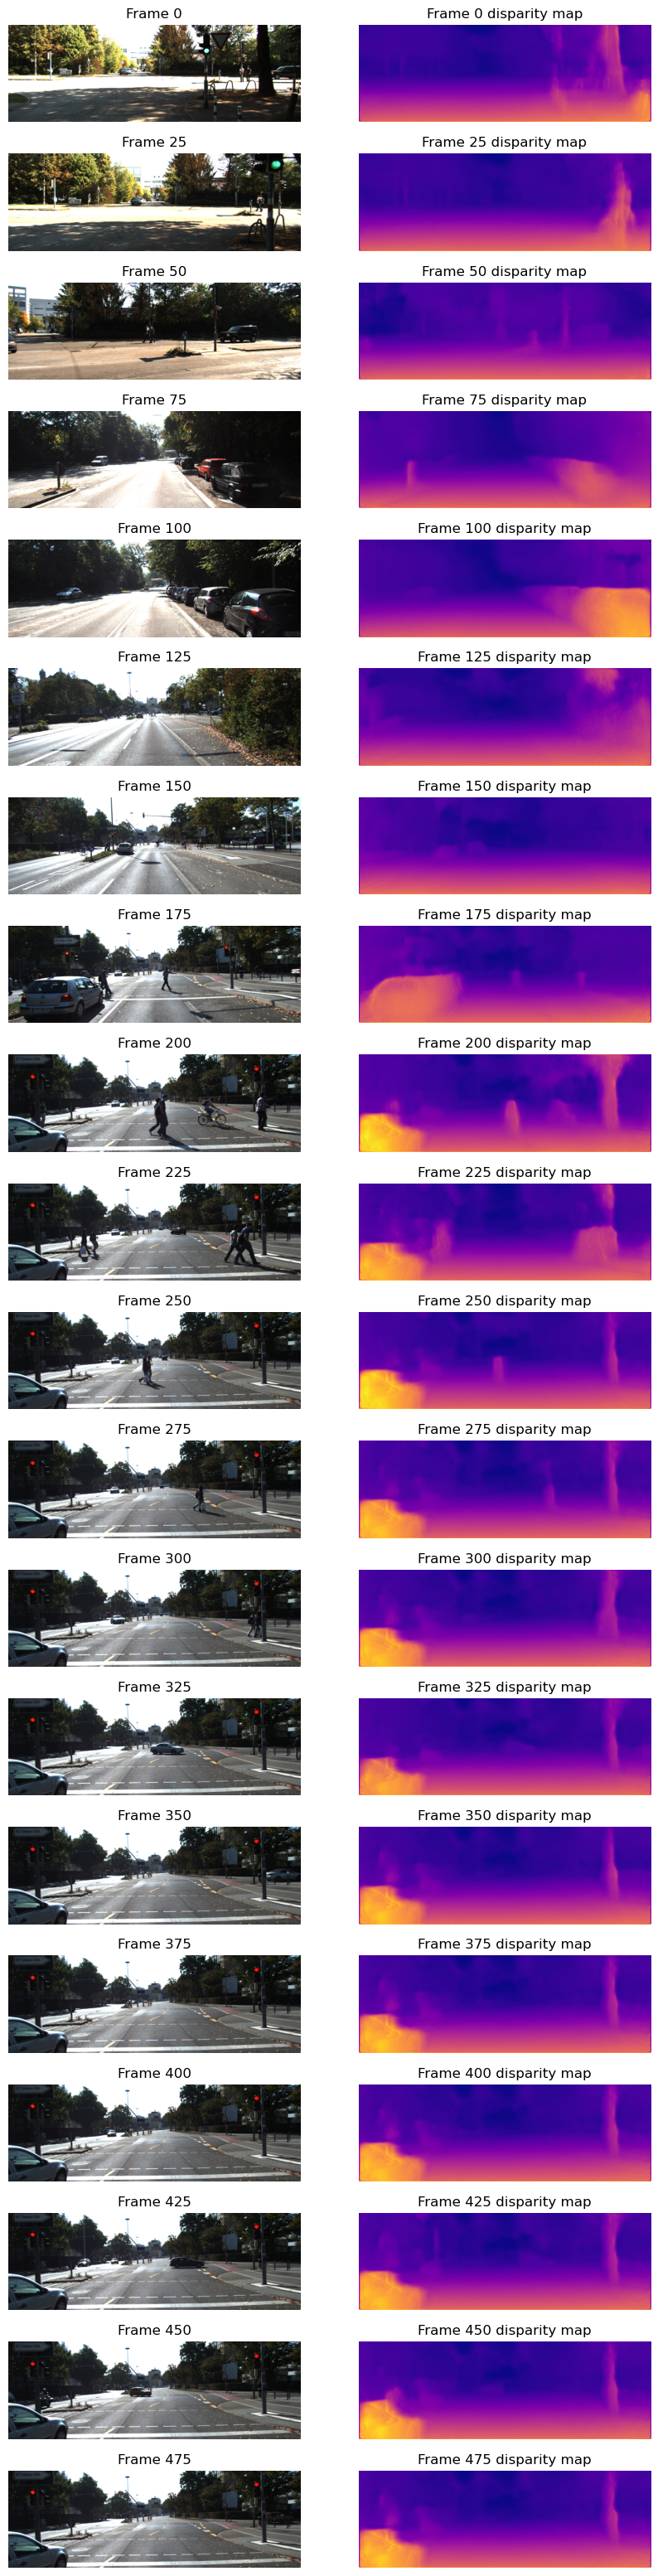

In [10]:
# Plot a few example images and estimated disparity maps (only left)
mono_depth_model.eval()

plt.figure().set_size_inches(10, 40)

for i, frame in enumerate(range(0, len(data_val), 25)):
    
    img_left, _ = data_val[frame]
    disp = mono_depth_model.blend_disp(img_left)

    plt.subplot(20, 2, 2*i+1)
    plt.imshow(img_left.permute(1, 2, 0).detach().numpy())
    plt.title(f'Frame {frame}')
    plt.gca().axis('off')

    plt.subplot(20, 2, 2*i+2)
    plt.imshow(disp.detach().numpy(), cmap='plasma')
    plt.title(f'Frame {frame} disparity map')
    plt.gca().axis('off')

Overall, one can see that although my results are not nearly as good as the results reported in the original paper (especially borders are detected a lot more accurately by the model from the original paper), in most of the cases the model is indeed able to produce reasonable results. While this is already impressive on the training data since this method is self-supervised and we did not give the model any prior ground-truth depth information, the results on the unseen validation data also look quite reasonable, although the shapes of some objects (as pedestrians or cars) in the image are not accurate.

## Conclusion

In this project, I implemented a self-supervised approach for monocular depth estimation and evaluated it on a chunk of the popular KITTI dataset of just over 15000 image pairs. For the most part, the training procedure was very noisy and unstable and training on the whole chunk of the data didn't even work as I had to use a model pre-trained to a smaller subset of the data in order to get the loss down to reasonable values. However, the fit of the model on the training data is satisfactory and it is obvious that the model seems to be capable of learning disparity information from stereo images. Considering that training happened without any ground truth data and the model was able to infer this information just from the image pairs and the constraints built into the model, this can already be seen as an achievement. Also, a qualitative evaluation of the results on a previously unseen chunk of the KITTI data shows that the model does a good job at generalizing.

There are multiple possible explanations for why the method performs worse than reported in the original paper: First, I only trained the model on about half the recommended minimum training size, also having to downsample the images due to my lack of time and computational resources.
If one would like to get the model to generalize better with just this smaller chunk of training data, one could try to reduce the complexity of the model by making it a bit smaller (i.e. maybe remove a couple of downsampling layers) or replacing some of the first encoder layers with pretrained CNN layers for object detection or semantic segmentation. 
Furthermore, the predicted disparities were rather smooth, almost never displaying any discontinuities, which contradicts the ground truth where there are often such discontinuities between different objects. To resolve this issue, one could try and further experiment with the disparity smoothness part of the loss, i.e. adjusting its weight or the way that the image gradient is taken into account. 